In [3]:
import pandas as pd
import numpy as np
import os
import sys
from IPython.display import Audio

import sklearn
from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe
from sktime.utils.data_container import from_nested_to_long
from sktime.utils.data_container import tabularize
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor, TSFreshRelevantFeatureExtractor
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sktime.utils.time_series import time_series_slope
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# with sktime, we can write this as a pipeline
from sktime.transformers.series_as_features.reduce import Tabularizer
from sklearn.pipeline import make_pipeline

import sktime as skt
import matplotlib.pyplot as plt
import seaborn as sns
from utils import dataset_selector
pd.set_option('max_colwidth', 4000)
plt.rcParams["figure.figsize"] = (30,3)
display(dataset_selector)


Dropdown(description='Dataset:', options=('ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGe…

In [258]:
data_folder = 'data/Univariate_ts'
dataset_name = dataset_selector.value
train_dataset_path = os.path.join(data_folder, dataset_name, dataset_name+"_TRAIN.ts")
test_dataset_path = os.path.join(data_folder, dataset_name, dataset_name+"_TEST.ts")
X_train, y_train  = load_from_tsfile_to_dataframe(train_dataset_path, replace_missing_vals_with='Nan')
X_test, y_test = load_from_tsfile_to_dataframe(test_dataset_path, replace_missing_vals_with='NaN')
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts, '\n')
#for label in labels:
#    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
#    for instance in X_train.loc[y_train == label, "dim_0"]:
#        ax.plot(instance)
#    ax.set(title=f"Instances of {label}")

['-1' '1'] [1860 1776] 



In [259]:
t_rel = TSFreshRelevantFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
t = TSFreshRelevantFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
if len(X_test) == len(y_test):
    X_train = t_rel.fit_transform(X_train, y_train)
    X_test = t_rel.transform(X_test, y_test)
    X_train.head()
else: print('Different lenghts')

Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

In [185]:
#Xt['target'] = y_train.astype(int)
#corr = Xt.corrwith(Xt["target"])
#Xt = Xt.drop(['target'], axis=1)
#corr.sort_values().plot(kind='bar')

In [250]:
X_train_scaled = preprocessing.scale(X_train.values)
X_test_scaled = preprocessing.scale(X_test.values)

y_train_offset = y_train.astype(int)
y_test_offset = y_test.astype(int)

print('X_train:', X_train_scaled.shape, type(X_train_scaled))
print('X_test:', X_test_scaled.shape, type(X_test_scaled))
print('y_train:', y_train_offset.shape, type(y_train_offset))
print('y_test:', y_test_offset.shape, type(y_test_offset))



X_train: (600, 699) <class 'numpy.ndarray'>
X_test: (600, 699) <class 'numpy.ndarray'>
y_train: (600,) <class 'numpy.ndarray'>
y_test: (600,) <class 'numpy.ndarray'>


In [255]:
window_len = X_test_scaled.shape[1]
num_labels = len(labels) 

model = models.Sequential()
model.add(layers.Dense(64, input_shape=(window_len,)))
model.add(layers.Dense(32,))
model.add(layers.Dense(32,))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(24,))
model.add(layers.Dense(16,))
model.add(layers.Dense(61, activation='softmax'))

model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

history = model.fit(X_train_scaled, y_train_offset, validation_split=0.1, epochs=50)


Train on 540 samples, validate on 60 samples
Epoch 1/50
540/540 [==============================] - 0s 861us/sample - loss: 4.2563 - accuracy: 0.0500 - val_loss: 4.6534 - val_accuracy: 0.0000e+00
Epoch 2/50
540/540 [==============================] - 0s 87us/sample - loss: 3.2198 - accuracy: 0.2204 - val_loss: 4.7180 - val_accuracy: 0.0000e+00
Epoch 3/50
540/540 [==============================] - 0s 85us/sample - loss: 2.7198 - accuracy: 0.3741 - val_loss: 5.1094 - val_accuracy: 0.0000e+00
Epoch 4/50
540/540 [==============================] - 0s 85us/sample - loss: 2.2653 - accuracy: 0.4741 - val_loss: 5.4379 - val_accuracy: 0.0000e+00
Epoch 5/50
540/540 [==============================] - 0s 81us/sample - loss: 1.8906 - accuracy: 0.5463 - val_loss: 5.6557 - val_accuracy: 0.0000e+00
Epoch 6/50
540/540 [==============================] - 0s 83us/sample - loss: 1.5787 - accuracy: 0.6167 - val_loss: 6.1682 - val_accuracy: 0.0000e+00
Epoch 7/50
540/540 [==============================] - 0s 87u

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


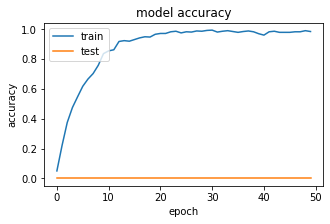

In [256]:
plt.rcParams["figure.figsize"] = (5,3)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


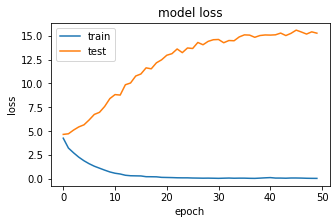

In [257]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
sound_filse = './beep.wav'


In [10]:
Audio(sound_file, autoplay=True)
